# VGG-18 CNN: PyTorch & CIFAR-10

End-to-end programming tutorial including:

1. Progress bar - training model
1. Train model with _early stopping criterion_
1. Learning rate scheduler
1. Compare between learning rate scheduler and early stopping criterion


In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms


from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"currently available device: {device}")

currently available device: cuda


In [4]:
print(f"PyTorch version: {torch.__version__}")

PyTorch version: 1.4.0


In [5]:
# Hyper-parameters-
num_epochs = 65
batch_size = 128
learning_rate = 0.01

In [6]:
# Define transformations for training and test sets-
transform_train = transforms.Compose(
    [
      transforms.RandomCrop(32, padding = 4),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
     ]
     )

transform_test = transforms.Compose(
    [
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
     ]
     )

In [7]:
# Load dataset-
train_dataset = torchvision.datasets.CIFAR10(
        root = './data', train = True,
        download = True, transform = transform_train
        )

test_dataset = torchvision.datasets.CIFAR10(
        root = './data', train = False,
        download = True, transform = transform_test
        )

Files already downloaded and verified
Files already downloaded and verified


In [8]:
print(f"len(train_dataset) = {len(train_dataset)} & len(test_dataset) = {len(test_dataset)}")

len(train_dataset) = 50000 & len(test_dataset) = 10000


In [9]:
# Create training and testing loaders-
train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size = batch_size,
        shuffle = True
        )

test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size = batch_size,
        shuffle = False
        )

In [10]:
print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_loader) = 391 & len(test_loader) = 79


In [11]:
# Sanity check-
len(train_dataset) / batch_size, len(test_dataset) / batch_size

(390.625, 78.125)

In [14]:
# Sanity check-
len(train_dataset) / batch_size, len(test_dataset) / batch_size

# Sanity check-
images, labels = next(iter(train_loader))

images.size(), labels.shape

(torch.Size([128, 3, 32, 32]), torch.Size([128]))

In [15]:
del images, labels

### Define _VGG_ architecture:

In [16]:
class VGGBlock(nn.Module):
    '''
    VGG block within a VGG-* CNN model
    '''
    def __init__(self, input_channels, num_channels, padding_size = 1,
                 stride_size = 1, use_extra_conv = False):
        super().__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels = input_channels, out_channels = num_channels,
            kernel_size = 3, padding = padding_size,
            stride = stride_size, bias = False
        )
        
        self.conv2 = nn.Conv2d(
            in_channels = num_channels, out_channels = num_channels,
            kernel_size = 3, padding = padding_size,
            stride = stride_size, bias = False
        )
        
        if use_extra_conv:
            self.conv3 = nn.Conv2d(
                in_channels = num_channels, out_channels = num_channels,
                kernel_size = 3, padding = padding_size,
                stride = stride_size, bias = False
            )
            
            self.conv4 = nn.Conv2d(
                in_channels = num_channels, out_channels = num_channels,
                kernel_size = 3, padding = padding_size,
                stride = stride_size, bias = False
            )
        else:
            self.conv3 = False
            self.conv4 = False
        
        self.pool = nn.MaxPool2d(
            kernel_size = 2, stride = 2)
            # padding = 1)
        
        self.bn1 = nn.BatchNorm2d(num_features = num_channels)
        self.bn2 = nn.BatchNorm2d(num_features = num_channels)

        if use_extra_conv:
            self.bn3 = nn.BatchNorm2d(num_features = num_channels)
            self.bn4 = nn.BatchNorm2d(num_features = num_channels)
        
        self.initialize_weights()
    
    
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = F.relu(self.bn2(self.conv2(Y)))
        
        if self.conv3 and self.conv4:
            Y = F.relu(self.bn3(self.conv3(Y)))
            Y = F.relu(self.bn4(self.conv4(Y)))
            Y = self.pool(Y)
        else:
            Y = self.pool(Y)
        
        return Y
    
    
    def shape_computation(self, X):
        Y = self.bn1(self.conv1(X))
        print(f"self.bn(conv1(X)).shape: {Y.shape}")
        
        Y = self.bn2(self.conv2(Y))
        print(f"self.bn(conv2(Y)).shape: {Y.shape}")
        
        if self.conv3 and self.conv4:
            Y = self.bn3(self.conv3(Y))
            print(f"self.bn(conv3(Y)).shape: {Y.shape}")
            
            Y = self.bn4(self.conv4(Y))
            print(f"self.bn(conv4(Y)).shape: {Y.shape}")
            
            Y = self.pool(Y)
            print(f"self.pool(Y).shape: {Y.shape}")
        else:
            Y = self.pool(Y)
            print(f"self.pool(Y).shape: {Y.shape}")
        

    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight)

                '''
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                '''
            
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)


In [14]:
class VGG18(nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = VGGBlock(input_channels = 3, num_channels = 64)
        self.block2 = VGGBlock(input_channels = 64, num_channels = 128)
        self.block3 = VGGBlock(input_channels = 128, num_channels = 256,
                use_extra_conv = True)
        self.block4 = VGGBlock(input_channels = 256, num_channels = 512,
                use_extra_conv = True)
        self.block5 = VGGBlock(input_channels = 512, num_channels = 512,
                use_extra_conv = True)

        # self.pool = nn.MaxPool2d(kernel_size = 1, stride = 1)
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(in_features = 512, out_features = 256)
        self.dense2 = nn.Linear(in_features = 512, out_features = 10)


    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        # x = self.pool(x)
        # print(f"After block5, x.shape: {x.shape}")
        # After block5, x.shape: torch.Size([128, 512, 1, 1]) 
        # x = torch.flatten(x)
        x = self.flatten(x)
        # print(f"After flattening, x.shape: {x.shape}")
        # After flattening, x.shape: torch.Size([128, 512]) 
        x = self.dense1(x)
        x = self.dense2(x) 
        return x


In [15]:
# model = VGG18()
# model.to(device)

In [16]:
# images = images.to(device)

In [17]:
# Sanity check-
# model(images).shape

In [17]:
# Initialize VGG-18 CNN model-
model = nn.Sequential(
    VGGBlock(input_channels = 3, num_channels = 64),
    VGGBlock(input_channels = 64, num_channels = 128),
    VGGBlock(input_channels = 128, num_channels = 256, use_extra_conv = True),
    VGGBlock(input_channels = 256, num_channels = 512, use_extra_conv = True),
    VGGBlock(input_channels = 512, num_channels = 512, use_extra_conv = True),
    nn.Flatten(),
    nn.Linear(in_features = 512, out_features = 256),
    nn.Linear(in_features = 256, out_features = 10)
    )


In [18]:
# Place model on GPU-
model.to(device)

Sequential(
  (0): VGGBlock(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): VGGBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): VGGBlock(
    (conv1): Conv2d(128

In [15]:
images = images.to(device)

In [16]:
# Sanity check-
model(images).shape

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([128, 10])

In [19]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

layer.shape = torch.Size([64, 3, 3, 3]) has 1728 parameters
layer.shape = torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([128, 64, 3, 3]) has 73728 parameters
layer.shape = torch.Size([128, 128, 3, 3]) has 147456 parameters
layer.shape = torch.Size([128]) has 128 parameters
layer.shape = torch.Size([128]) has 128 parameters
layer.shape = torch.Size([128]) has 128 parameters
layer.shape = torch.Size([128]) has 128 parameters
layer.shape = torch.Size([256, 128, 3, 3]) has 294912 parameters
layer.shape = torch.Size([256, 256, 3, 3]) has 589824 parameters
layer.shape = torch.Size([256, 256, 3, 3]) has 589824 parameters
layer.shape = torch.Size([256, 256, 3, 3]) has 589824 parameters
layer.shape = torch.Size([256]) has 256 parameters
layer.shape = torch.Size([256]) has 256

In [20]:
print(f"Total number of parameters in VGG-18 CNN = {tot_params}")

Total number of parameters in VGG-18 CNN = 20163786


In [ ]:
'''
# Print layer names-
for layer in model.state_dict().keys():
    print(f"{layer} has dimension = {model.state_dict()[layer].shape}")
'''

In [18]:
# Save random initial weights-
torch.save(model.state_dict(), 'VGG18_random_weights.pth')

In [21]:
# Load randomly initialised weights-
# model.load_state_dict(torch.load('VGG18_random_weights.pth'))

<All keys matched successfully>

In [19]:
# Define loss function and optimizer-
loss = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 5e-4)

In [ ]:
def train_step(model, train_loader):
    running_loss = 0.0
    running_corrects = 0.0

    for batch, (images, labels) in enumerate(train_loader):
        # Attempt to push to GPU if available
        images = images.to(device)
        labels = labels.to(device)

        # print(f"batch # = {batch}")

        model.train()

        # Forward pass-
        outputs = model(images)

        # Compute loss-
        J = loss(outputs, labels)

        # Backward pass-
        optimizer.zero_grad()   # empty accumulated gradients

        J.backward()    # perform backpropagation

        # Updates parameters-
        optimizer.step()
        
        # Compute model's performance statistics-
        running_loss += J.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        running_corrects += torch.sum(predicted == labels.data)

        '''
        # Print information every 100 steps-
        if (batch + 1) % 100 == 0:
            print(f"epoch {epoch + 1}/{num_epochs}, step {batch + 1}/{num_training_steps}, loss = {J.item():.4f}")
        '''

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = (running_corrects.double() / len(train_dataset)) * 100
    
    return epoch_loss, epoch_acc.cpu().numpy()
    


In [21]:
def train_model_progress(model, train_loader):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and number of correct predictions for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0
    
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            J = loss(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100
    

    # return running_loss, running_corrects
    return train_loss, train_acc.cpu().numpy()
    


In [ ]:
def validate_step(model, test_loader):
    total, correct = 0, 0
    running_loss_val = 0.0

    with torch.no_grad():
        for images, labels in test_loader:

            # Place features (images) and targets (labels) to GPU-
            images = images.to(device)
            labels = labels.to(device)

            # Set model to evaluation mode-
            model.eval()
    
            # Make predictions using trained model-
            outputs = model(images)
            _, y_pred = torch.max(outputs, 1)

            # Compute validation loss-
            J_val = loss(outputs, labels)

            running_loss_val += J_val.item() * labels.size(0)
    
            # Total number of labels-
            total += labels.size(0)

            # Total number of correct predictions-
            correct += (y_pred == labels).sum()

    epoch_val_loss = running_loss_val / len(test_dataset)
    val_acc = 100 * (correct / total)

    return epoch_val_loss, val_acc.cpu().numpy()


In [22]:
def test_model_progress(model, test_loader):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                
                # Set model to evaluation mode-
                model.eval()
            
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.cpu().numpy()


In [33]:
# Sanity check-
train_loss, train_acc = train_model_progress(model, train_loader)

Training: : 100%|██████████| 391/391 [04:08<00:00,  1.57batch/s, accuracy=45.5, loss=1.47]


In [34]:
# Sanity check-
val_loss, val_acc = test_model_progress(model, test_loader)

Validation: : 100%|██████████| 79/79 [00:08<00:00,  9.06batch/s, val_acc=56.6, val_loss=1.21]


### Train model _without_ learning rate scheduler, using early-stopping criterion

In [21]:
# Initialize parameters for Early Stopping manual implementation-
best_val_loss = 100
loc_patience = 0

In [22]:
# User input parameters for Early Stopping in manual implementation-
minimum_delta = 0.001
patience = 3

In [25]:
training_history = {}

In [ ]:
for epoch in range(num_epochs):

    if loc_patience >= patience:
        print("\n'EarlyStopping' called!\n")
        break

    train_loss, train_acc = train_model_progress(model, train_loader)
    val_loss, val_acc = test_model_progress(model, test_loader)
    
    print(f"\nepoch: {epoch + 1} training loss = {train_loss:.4f}, "
          f"training accuracy = {train_acc:.2f}%, val_loss = {val_loss:.4f}"
          f", val_accuracy = {val_acc:.2f}% & "
          f"LR = {optimizer.param_groups[0]['lr']:.4f}\n")
    
    training_history[epoch + 1] = {
        'loss': train_loss, 'acc': train_acc,
        'val_loss': val_loss, 'val_acc': val_acc,
        'lr': optimizer.param_groups[0]['lr']
    }

    '''
    # Save best weights achieved until now-
    if (val_loss < best_val_loss):    
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = val_loss

        print(f"Saving model with lowest val_loss = {val_loss:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "VGG18_best_model.pth")
    '''

    # Code for manual Early Stopping:
    # if np.abs(val_loss < best_val_loss) >= minimum_delta:
    if (val_loss < best_val_loss) and \
    (np.abs(val_loss - best_val_loss) >= minimum_delta):

        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = val_loss
        
        # reset 'loc_patience' variable-
        loc_patience = 0

        print(f"Saving model with lowest val_loss = {val_loss:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "VGG18_best_model.pth")
        
    else:  # there is no improvement in monitored metric 'val_loss'
        loc_patience += 1  # number of epochs without any improvement
    

In [27]:
training_history.keys()

dict_keys([1, 2, 3, 4, 5, 6])

In [28]:
training_history[2].keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])

In [29]:
training_history[2]['val_acc']

array(68.95, dtype=float32)

In [ ]:
import pickle

In [ ]:
with open("VGG19_training_history.pkl", "wb") as file:
    pickle.dump(training_history, file)

In [ ]:
# Save trained weights-
torch.save(model.state_dict(), 'VGG19_trained_weights.pth')

### Train model with _learning rate scheduler_

- Training dataset = 50000, batch size = 128, number of training steps/iterations = 50000 / 128 = 391

- Initial learning rate warmup: 391 x 10 = 3910 steps or, 10 epochs at LR = 0.1

- Until 25th epoch or, 9775 steps use LR = 0.1

- From 26th epoch until 40th epoch or, 15640 steps use LR = 0.01

- From 41st epoch until 50th epoch or, 19550 steps use LR = 0.001

- From 51st epoch until 60th epoch use LR = 0.0001

In [ ]:
boundaries = [9775, 15640, 19550]
values = [0.1, 0.01, 0.001, 0.0001]

In [22]:
# Define loss function and optimizer-
loss = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.0, momentum = 0.9, weight_decay = 5e-4)

In [23]:
# Sanity check-
optimizer.param_groups[0]['lr']

0.0

In [24]:
def decay_function(step, boundaries = [9775, 15640, 19550], values = [0.1, 0.01, 0.001, 0.0001]):
    '''
    1 epoch has 391 steps/iterations using batch size used above.
    
    Until 25th epochs, or 25 x 391 = 9775 steps, use lr = 0.1
    From 26th epoch until 40th epoch, or 15640 steps use LR = 0.01
    From 41st epoch until 50th epoch or, 19550 steps use LR = 0.001
    From 51st epoch until 60th epoch use LR = 0.0001
    '''
    
    for idx, bound in enumerate(boundaries):
        if step < bound:
            return values[idx]

    return values[-1]


In [20]:
"""
def decay_function(step, boundaries = [15640, 19550], values = [0.01, 0.001, 0.0001]):
    '''
    1 epoch has 391 steps/iterations using batch size used above.
    
    Until 40 epochs, or 40 x 391 = 15640 steps, use lr = 0.01
    Until 50 epochs, or 50 x 391 = 19550 steps, use lr = 0.001
    
    For any remaining steps, use lr = 0.0001
    '''
    
    for idx, bound in enumerate(boundaries):
        if step < bound:
            return values[idx]

    return values[-1]
"""

In [ ]:
# decay_function(step = 2, boundaries = [0, 2, 4, 6, 8, 10], values = [10, 15, 20, 30, 40, 50, 60])

In [25]:
class schedule():

    def __init__(self, initial_learning_rate = 0.1, warmup_steps = 1000, decay_func = None):
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.decay_func = decay_func
        self.warmup_step_size = initial_learning_rate/warmup_steps
        self.current_lr = 0

    def get_lr(self, step):
        if step == 0:
            return self.current_lr
        elif step <= self.warmup_steps:
            self.current_lr+=self.warmup_step_size
            return self.current_lr
        elif step > self.warmup_steps:
            if self.decay_func:
                return self.decay_func(step)
        else:
            return self.current_lr


In [26]:
# 391 x 10 = 3910 steps (or, 10 epochs) is learning rate warmup
custom_lr_scheduler = schedule(
    initial_learning_rate = 0.1, warmup_steps = 3910,
    decay_func = decay_function
)

In [27]:
step = 0

In [28]:
def train_model_progress(model, train_loader):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and number of correct predictions for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0
    
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            J = loss(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            global step
            optimizer.param_groups[0]['lr'] = custom_lr_scheduler.get_lr(step)

            step += 1
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100
    

    # return running_loss, running_corrects
    return train_loss, train_acc.cpu().numpy()
    


In [29]:
def test_model_progress(model, test_loader):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                
                # Set model to evaluation mode-
                model.eval()
            
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.cpu().numpy()


In [30]:
training_history_lr_scheduler = {}

In [31]:
# Initialize parameters for Early Stopping manual implementation-
best_val_loss = 100
loc_patience = 0

In [32]:
for epoch in range(num_epochs):

    train_loss, train_acc = train_model_progress(model, train_loader)
    val_loss, val_acc = test_model_progress(model, test_loader)
    
    print(f"\nepoch: {epoch + 1} training loss = {train_loss:.4f}, "
          f"training accuracy = {train_acc:.2f}%, val_loss = {val_loss:.4f}"
          f", val_accuracy = {val_acc:.2f}% & "
          f"LR = {optimizer.param_groups[0]['lr']:.4f}\n")
    
    training_history_lr_scheduler[epoch + 1] = {
        'loss': train_loss, 'acc': train_acc,
        'val_loss': val_loss, 'val_acc': val_acc,
        'lr': optimizer.param_groups[0]['lr']
    }

    
    # Save best weights achieved until now-
    if (val_loss < best_val_loss):    
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = val_loss

        print(f"Saving model with lowest val_loss = {val_loss:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "VGG18_best_model.pth")
    


Validation: : 100%|██████████| 79/79 [00:03<00:00, 20.66batch/s, val_acc=43.1, val_loss=1.64] 



epoch: 1 training loss = 1.6787, training accuracy = 37.69%, val_loss = 1.6412, val_accuracy = 43.06% & LR = 0.0100

Saving model with lowest val_loss = 1.6412



Validation: : 100%|██████████| 79/79 [00:03<00:00, 20.97batch/s, val_acc=54.5, val_loss=1.47] 



epoch: 2 training loss = 1.1516, training accuracy = 59.24%, val_loss = 1.4725, val_accuracy = 54.51% & LR = 0.0200

Saving model with lowest val_loss = 1.4725



Validation: : 100%|██████████| 79/79 [00:03<00:00, 20.85batch/s, val_acc=65.2, val_loss=1.08] 



epoch: 3 training loss = 0.9084, training accuracy = 68.85%, val_loss = 1.0850, val_accuracy = 65.18% & LR = 0.0300

Saving model with lowest val_loss = 1.0850



Validation: : 100%|██████████| 79/79 [00:03<00:00, 20.65batch/s, val_acc=70.2, val_loss=0.939]



epoch: 4 training loss = 0.7946, training accuracy = 73.35%, val_loss = 0.9393, val_accuracy = 70.17% & LR = 0.0400

Saving model with lowest val_loss = 0.9393



Validation: : 100%|██████████| 79/79 [00:03<00:00, 20.77batch/s, val_acc=74.1, val_loss=0.805]



epoch: 5 training loss = 0.7191, training accuracy = 76.40%, val_loss = 0.8054, val_accuracy = 74.11% & LR = 0.0500

Saving model with lowest val_loss = 0.8054



Training: :   0%|          | 1/391 [00:00<00:39,  9.82batch/s, accuracy=0.192, loss=0.00187]


epoch: 6 training loss = 0.6707, training accuracy = 77.87%, val_loss = 1.0103, val_accuracy = 67.59% & LR = 0.0600



Training: :   0%|          | 1/391 [00:00<00:42,  9.10batch/s, accuracy=0.202, loss=0.00151]


epoch: 7 training loss = 0.6385, training accuracy = 78.95%, val_loss = 0.8188, val_accuracy = 75.74% & LR = 0.0700



Validation: : 100%|██████████| 79/79 [00:03<00:00, 20.84batch/s, val_acc=76.5, val_loss=0.695]



epoch: 8 training loss = 0.6040, training accuracy = 80.47%, val_loss = 0.6952, val_accuracy = 76.53% & LR = 0.0800

Saving model with lowest val_loss = 0.6952



Training: :   0%|          | 1/391 [00:00<00:39,  9.80batch/s, accuracy=0.198, loss=0.00167]


epoch: 9 training loss = 0.5940, training accuracy = 80.55%, val_loss = 0.7505, val_accuracy = 74.97% & LR = 0.0900



Validation: : 100%|██████████| 79/79 [00:03<00:00, 20.75batch/s, val_acc=78.8, val_loss=0.647] 



epoch: 10 training loss = 0.5822, training accuracy = 81.14%, val_loss = 0.6468, val_accuracy = 78.76% & LR = 0.1000

Saving model with lowest val_loss = 0.6468



Training: :   0%|          | 1/391 [00:00<00:39,  9.78batch/s, accuracy=0.212, loss=0.00132]


epoch: 11 training loss = 0.5772, training accuracy = 81.52%, val_loss = 0.7464, val_accuracy = 75.75% & LR = 0.1000



Training: :   1%|          | 2/391 [00:00<00:38, 10.01batch/s, accuracy=0.424, loss=0.00269]


epoch: 12 training loss = 0.5568, training accuracy = 82.24%, val_loss = 0.8409, val_accuracy = 75.58% & LR = 0.1000



Training: :   0%|          | 1/391 [00:00<00:39,  9.85batch/s, accuracy=0.222, loss=0.00117]


epoch: 13 training loss = 0.5440, training accuracy = 82.40%, val_loss = 0.7070, val_accuracy = 77.72% & LR = 0.1000



Validation: : 100%|██████████| 79/79 [00:03<00:00, 20.70batch/s, val_acc=80.6, val_loss=0.594] 



epoch: 14 training loss = 0.5249, training accuracy = 83.09%, val_loss = 0.5938, val_accuracy = 80.56% & LR = 0.1000

Saving model with lowest val_loss = 0.5938



Training: :   0%|          | 1/391 [00:00<00:39,  9.79batch/s, accuracy=0.22, loss=0.00123]


epoch: 15 training loss = 0.5308, training accuracy = 82.81%, val_loss = 0.8716, val_accuracy = 72.43% & LR = 0.1000



Training: :   0%|          | 1/391 [00:00<00:39,  9.90batch/s, accuracy=0.21, loss=0.00147]


epoch: 16 training loss = 0.5253, training accuracy = 82.75%, val_loss = 0.6995, val_accuracy = 78.09% & LR = 0.1000



Training: :   0%|          | 1/391 [00:00<00:39,  9.91batch/s, accuracy=0.226, loss=0.001]


epoch: 17 training loss = 0.5195, training accuracy = 83.30%, val_loss = 0.6209, val_accuracy = 79.99% & LR = 0.1000



Training: :   0%|          | 1/391 [00:00<00:39,  9.83batch/s, accuracy=0.22, loss=0.00108]


epoch: 18 training loss = 0.5113, training accuracy = 83.61%, val_loss = 0.9670, val_accuracy = 70.93% & LR = 0.1000



Training: :   0%|          | 1/391 [00:00<00:39,  9.98batch/s, accuracy=0.462, loss=0.00191] 


epoch: 19 training loss = 0.5076, training accuracy = 83.85%, val_loss = 1.2845, val_accuracy = 70.00% & LR = 0.1000



Training: :   0%|          | 1/391 [00:00<00:40,  9.72batch/s, accuracy=0.22, loss=0.00125]


epoch: 20 training loss = 0.5038, training accuracy = 83.86%, val_loss = 0.6033, val_accuracy = 80.75% & LR = 0.1000



Training: :   1%|          | 2/391 [00:00<00:38, 10.15batch/s, accuracy=0.428, loss=0.00252]


epoch: 21 training loss = 0.4965, training accuracy = 84.17%, val_loss = 1.1922, val_accuracy = 69.90% & LR = 0.1000



Training: :   0%|          | 1/391 [00:00<00:39,  9.95batch/s, accuracy=0.446, loss=0.00225]


epoch: 22 training loss = 0.4896, training accuracy = 84.38%, val_loss = 0.7497, val_accuracy = 76.97% & LR = 0.1000



Training: :   0%|          | 1/391 [00:00<00:40,  9.74batch/s, accuracy=0.22, loss=0.00127]


epoch: 23 training loss = 0.4896, training accuracy = 84.51%, val_loss = 0.8486, val_accuracy = 76.61% & LR = 0.1000



Training: :   0%|          | 1/391 [00:00<00:39,  9.85batch/s, accuracy=0.208, loss=0.00158]


epoch: 24 training loss = 0.4837, training accuracy = 84.54%, val_loss = 0.6761, val_accuracy = 77.60% & LR = 0.1000



Training: :   0%|          | 1/391 [00:00<00:40,  9.75batch/s, accuracy=0.224, loss=0.00104]


epoch: 25 training loss = 0.4846, training accuracy = 84.66%, val_loss = 0.6006, val_accuracy = 80.57% & LR = 0.1000



Validation: : 100%|██████████| 79/79 [00:03<00:00, 20.75batch/s, val_acc=90.6, val_loss=0.287] 



epoch: 26 training loss = 0.2758, training accuracy = 90.95%, val_loss = 0.2875, val_accuracy = 90.63% & LR = 0.0100

Saving model with lowest val_loss = 0.2875



Validation: : 100%|██████████| 79/79 [00:03<00:00, 20.57batch/s, val_acc=90.9, val_loss=0.272] 



epoch: 27 training loss = 0.2118, training accuracy = 92.97%, val_loss = 0.2720, val_accuracy = 90.90% & LR = 0.0100

Saving model with lowest val_loss = 0.2720



Training: :   0%|          | 1/391 [00:00<00:39,  9.83batch/s, accuracy=0.236, loss=0.000653]


epoch: 28 training loss = 0.1927, training accuracy = 93.62%, val_loss = 0.2748, val_accuracy = 91.13% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:03<00:00, 20.76batch/s, val_acc=91.7, val_loss=0.257] 



epoch: 29 training loss = 0.1750, training accuracy = 94.20%, val_loss = 0.2568, val_accuracy = 91.66% & LR = 0.0100

Saving model with lowest val_loss = 0.2568



Validation: : 100%|██████████| 79/79 [00:03<00:00, 20.97batch/s, val_acc=91.8, val_loss=0.252] 



epoch: 30 training loss = 0.1560, training accuracy = 94.83%, val_loss = 0.2524, val_accuracy = 91.85% & LR = 0.0100

Saving model with lowest val_loss = 0.2524



Training: :   0%|          | 1/391 [00:00<00:40,  9.62batch/s, accuracy=0.244, loss=0.000411]


epoch: 31 training loss = 0.1469, training accuracy = 95.13%, val_loss = 0.2605, val_accuracy = 91.70% & LR = 0.0100



Training: :   0%|          | 1/391 [00:00<00:39,  9.93batch/s, accuracy=0.494, loss=0.000461]


epoch: 32 training loss = 0.1345, training accuracy = 95.48%, val_loss = 0.2613, val_accuracy = 91.67% & LR = 0.0100



Training: :   0%|          | 1/391 [00:00<00:42,  9.12batch/s, accuracy=0.252, loss=0.0002]


epoch: 33 training loss = 0.1265, training accuracy = 95.75%, val_loss = 0.2634, val_accuracy = 91.69% & LR = 0.0100



Training: :   0%|          | 1/391 [00:00<00:39,  9.83batch/s, accuracy=0.252, loss=0.000163]


epoch: 34 training loss = 0.1200, training accuracy = 96.01%, val_loss = 0.2610, val_accuracy = 91.96% & LR = 0.0100



Training: :   0%|          | 1/391 [00:00<00:39,  9.82batch/s, accuracy=0.244, loss=0.000347]


epoch: 35 training loss = 0.1118, training accuracy = 96.29%, val_loss = 0.2605, val_accuracy = 92.08% & LR = 0.0100



Training: :   0%|          | 1/391 [00:00<00:44,  8.76batch/s, accuracy=0.248, loss=0.000211]


epoch: 36 training loss = 0.1032, training accuracy = 96.62%, val_loss = 0.2623, val_accuracy = 92.24% & LR = 0.0100



Training: :   0%|          | 1/391 [00:00<00:40,  9.74batch/s, accuracy=0.246, loss=0.000444]


epoch: 37 training loss = 0.1015, training accuracy = 96.57%, val_loss = 0.2957, val_accuracy = 91.37% & LR = 0.0100



Training: :   0%|          | 1/391 [00:00<00:39,  9.98batch/s, accuracy=0.252, loss=0.000173]


epoch: 38 training loss = 0.0960, training accuracy = 96.80%, val_loss = 0.2850, val_accuracy = 91.69% & LR = 0.0100



Training: :   0%|          | 1/391 [00:00<00:39,  9.85batch/s, accuracy=0.25, loss=0.000182]


epoch: 39 training loss = 0.0912, training accuracy = 96.92%, val_loss = 0.3076, val_accuracy = 90.91% & LR = 0.0100



Training: :   0%|          | 1/391 [00:00<00:39,  9.94batch/s, accuracy=0.248, loss=0.000177]


epoch: 40 training loss = 0.0906, training accuracy = 96.96%, val_loss = 0.2855, val_accuracy = 91.57% & LR = 0.0100



Training: :   0%|          | 1/391 [00:00<00:41,  9.41batch/s, accuracy=0.252, loss=0.000155]


epoch: 41 training loss = 0.0605, training accuracy = 98.04%, val_loss = 0.2597, val_accuracy = 92.52% & LR = 0.0010



Training: :   0%|          | 1/391 [00:00<00:39,  9.90batch/s, accuracy=0.256, loss=2.81e-5]


epoch: 42 training loss = 0.0484, training accuracy = 98.47%, val_loss = 0.2621, val_accuracy = 92.65% & LR = 0.0010



Training: :   0%|          | 1/391 [00:00<00:40,  9.74batch/s, accuracy=0.254, loss=6.24e-5]


epoch: 43 training loss = 0.0436, training accuracy = 98.61%, val_loss = 0.2621, val_accuracy = 92.71% & LR = 0.0010



Training: :   0%|          | 1/391 [00:00<00:40,  9.72batch/s, accuracy=0.254, loss=8.41e-5]


epoch: 44 training loss = 0.0403, training accuracy = 98.69%, val_loss = 0.2633, val_accuracy = 92.81% & LR = 0.0010



Training: :   0%|          | 1/391 [00:00<00:39,  9.89batch/s, accuracy=0.252, loss=0.000111]


epoch: 45 training loss = 0.0380, training accuracy = 98.82%, val_loss = 0.2665, val_accuracy = 92.86% & LR = 0.0010



Training: :   0%|          | 1/391 [00:00<00:39,  9.92batch/s, accuracy=0.256, loss=4.24e-5]


epoch: 46 training loss = 0.0345, training accuracy = 98.91%, val_loss = 0.2685, val_accuracy = 92.71% & LR = 0.0010



Training: :   1%|          | 2/391 [00:00<00:38, 10.03batch/s, accuracy=0.506, loss=0.000239]


epoch: 47 training loss = 0.0339, training accuracy = 98.96%, val_loss = 0.2720, val_accuracy = 92.78% & LR = 0.0010



Training: :   0%|          | 1/391 [00:00<00:39,  9.88batch/s, accuracy=0.256, loss=4.67e-5]


epoch: 48 training loss = 0.0310, training accuracy = 99.01%, val_loss = 0.2734, val_accuracy = 92.72% & LR = 0.0010



Training: :   0%|          | 1/391 [00:00<00:39,  9.87batch/s, accuracy=0.506, loss=0.000198]


epoch: 49 training loss = 0.0321, training accuracy = 99.02%, val_loss = 0.2753, val_accuracy = 92.83% & LR = 0.0010



Training: :   0%|          | 1/391 [00:00<00:39,  9.76batch/s, accuracy=0.252, loss=5.83e-5]


epoch: 50 training loss = 0.0290, training accuracy = 99.09%, val_loss = 0.2770, val_accuracy = 92.65% & LR = 0.0010



Training: :   0%|          | 1/391 [00:00<00:40,  9.70batch/s, accuracy=0.254, loss=4.88e-5]


epoch: 51 training loss = 0.0280, training accuracy = 99.19%, val_loss = 0.2775, val_accuracy = 92.71% & LR = 0.0001



Training: :   0%|          | 1/391 [00:00<00:39,  9.89batch/s, accuracy=0.256, loss=2.45e-5]


epoch: 52 training loss = 0.0264, training accuracy = 99.19%, val_loss = 0.2755, val_accuracy = 92.76% & LR = 0.0001



Training: :   0%|          | 1/391 [00:00<00:39,  9.99batch/s, accuracy=0.252, loss=0.000115]


epoch: 53 training loss = 0.0265, training accuracy = 99.17%, val_loss = 0.2773, val_accuracy = 92.80% & LR = 0.0001



Training: :   0%|          | 1/391 [00:00<00:39,  9.85batch/s, accuracy=0.51, loss=0.000103]


epoch: 54 training loss = 0.0263, training accuracy = 99.20%, val_loss = 0.2778, val_accuracy = 92.84% & LR = 0.0001



Training: :   0%|          | 1/391 [00:00<00:39,  9.75batch/s, accuracy=0.254, loss=9.61e-5]


epoch: 55 training loss = 0.0257, training accuracy = 99.26%, val_loss = 0.2773, val_accuracy = 92.83% & LR = 0.0001



Training: :   0%|          | 1/391 [00:00<00:39,  9.81batch/s, accuracy=0.256, loss=1.11e-5]


epoch: 56 training loss = 0.0261, training accuracy = 99.21%, val_loss = 0.2770, val_accuracy = 92.81% & LR = 0.0001



Training: :   0%|          | 1/391 [00:00<00:39,  9.91batch/s, accuracy=0.254, loss=3.78e-5]


epoch: 57 training loss = 0.0256, training accuracy = 99.24%, val_loss = 0.2781, val_accuracy = 92.79% & LR = 0.0001



Training: :   0%|          | 1/391 [00:00<00:40,  9.68batch/s, accuracy=0.254, loss=5.81e-5]


epoch: 58 training loss = 0.0265, training accuracy = 99.18%, val_loss = 0.2782, val_accuracy = 92.76% & LR = 0.0001



Training: :   0%|          | 1/391 [00:00<00:39,  9.85batch/s, accuracy=0.254, loss=7.3e-5]


epoch: 59 training loss = 0.0242, training accuracy = 99.24%, val_loss = 0.2767, val_accuracy = 92.78% & LR = 0.0001



Training: :   0%|          | 1/391 [00:00<00:39,  9.84batch/s, accuracy=0.252, loss=8.08e-5]


epoch: 60 training loss = 0.0252, training accuracy = 99.20%, val_loss = 0.2772, val_accuracy = 92.71% & LR = 0.0001



Training: :   0%|          | 1/391 [00:00<00:39,  9.94batch/s, accuracy=0.506, loss=9.51e-5]


epoch: 61 training loss = 0.0236, training accuracy = 99.29%, val_loss = 0.2762, val_accuracy = 92.90% & LR = 0.0001



Training: :   0%|          | 1/391 [00:00<00:40,  9.70batch/s, accuracy=0.254, loss=0.000108]


epoch: 62 training loss = 0.0250, training accuracy = 99.21%, val_loss = 0.2789, val_accuracy = 92.90% & LR = 0.0001



Training: :   0%|          | 1/391 [00:00<00:40,  9.72batch/s, accuracy=0.254, loss=5.13e-5]


epoch: 63 training loss = 0.0241, training accuracy = 99.25%, val_loss = 0.2779, val_accuracy = 92.82% & LR = 0.0001



Training: :   0%|          | 1/391 [00:00<00:39,  9.85batch/s, accuracy=0.254, loss=5.39e-5]


epoch: 64 training loss = 0.0238, training accuracy = 99.29%, val_loss = 0.2760, val_accuracy = 92.85% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:03<00:00, 21.10batch/s, val_acc=92.9, val_loss=0.278] 


epoch: 65 training loss = 0.0242, training accuracy = 99.27%, val_loss = 0.2782, val_accuracy = 92.92% & LR = 0.0001



In [37]:
# Save model from last training epoch-
torch.save(model.state_dict(), "VGG18_last_epoch_model.pth")

In [64]:
# Sanity check- Load model from before-
best_model = nn.Sequential(
    VGGBlock(input_channels = 3, num_channels = 64),
    VGGBlock(input_channels = 64, num_channels = 128),
    VGGBlock(input_channels = 128, num_channels = 256, use_extra_conv = True),
    VGGBlock(input_channels = 256, num_channels = 512, use_extra_conv = True),
    VGGBlock(input_channels = 512, num_channels = 512, use_extra_conv = True),
    nn.Flatten(),
    nn.Linear(in_features = 512, out_features = 256),
    nn.Linear(in_features = 256, out_features = 10)
    )


In [66]:
best_model.load_state_dict(torch.load('VGG18_best_model.pth'))

<All keys matched successfully>

In [ ]:
# Place model on GPU-
best_model.to(device)

In [68]:
val_loss, val_acc = test_model_progress(best_model, test_loader)

Validation: : 100%|██████████| 79/79 [00:03<00:00, 20.76batch/s, val_acc=91.8, val_loss=0.252] 


In [69]:
print(f"VGG-18 'best' model metrics: val_loss = {val_loss:.4f} & val_acc = {val_acc:.2f}%")

VGG-18 'best' model metrics: val_loss = 0.2524 & val_acc = 91.85%


In [70]:
del best_model

In [52]:
# Sanity check- Load model from before-
trained_model = nn.Sequential(
    VGGBlock(input_channels = 3, num_channels = 64),
    VGGBlock(input_channels = 64, num_channels = 128),
    VGGBlock(input_channels = 128, num_channels = 256, use_extra_conv = True),
    VGGBlock(input_channels = 256, num_channels = 512, use_extra_conv = True),
    VGGBlock(input_channels = 512, num_channels = 512, use_extra_conv = True),
    nn.Flatten(),
    nn.Linear(in_features = 512, out_features = 256),
    nn.Linear(in_features = 256, out_features = 10)
    )


In [53]:
trained_model.load_state_dict(torch.load('VGG18_last_epoch_model.pth'))

<All keys matched successfully>

In [ ]:
# Place model on GPU-
trained_model.to(device)

In [55]:
val_loss, val_acc = test_model_progress(trained_model, test_loader)

Validation: : 100%|██████████| 79/79 [00:03<00:00, 20.96batch/s, val_acc=92.9, val_loss=0.278] 


In [57]:
print(f"VGG-18 trained model metrics: val_loss = {val_loss:.4f} & val_acc = {val_acc:.2f}%")

VGG-18 trained model metrics: val_loss = 0.2782 & val_acc = 92.92%


In [58]:
del trained_model

### Observation:

For this particular experiment, it seems that using ```val_loss``` as the metric to save the _best_ model is not the optimum choice.

_Highest validation accuracy_ achieved = 92.92%.

In [33]:
# Sanity check-
training_history_lr_scheduler.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65])

In [34]:
training_history_lr_scheduler[12].keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])

In [35]:
import pickle

In [36]:
# Save training metrics as Python3 history for later analysis-
with open("VGG18_training_history_lr_scheduler.pkl", "wb") as file:
    pickle.dump(training_history_lr_scheduler, file)

### Training Visualizations

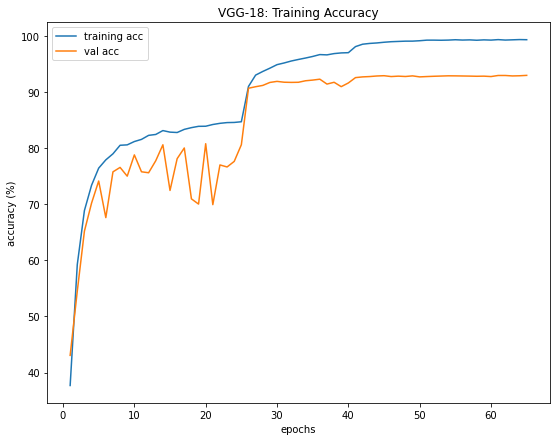

In [60]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['acc'] for k in training_history_lr_scheduler.keys()], label = 'training acc')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_acc'] for k in training_history_lr_scheduler.keys()], label = 'val acc')
plt.title("VGG-18: Training Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(loc = 'best')
plt.show()

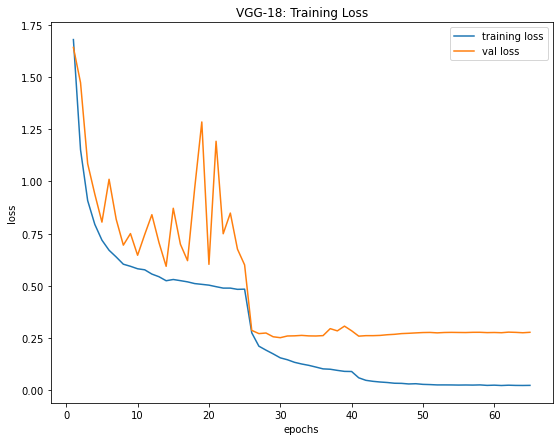

In [61]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['loss'] for k in training_history_lr_scheduler.keys()], label = 'training loss')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_loss'] for k in training_history_lr_scheduler.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("VGG-18: Training Loss")
plt.show()

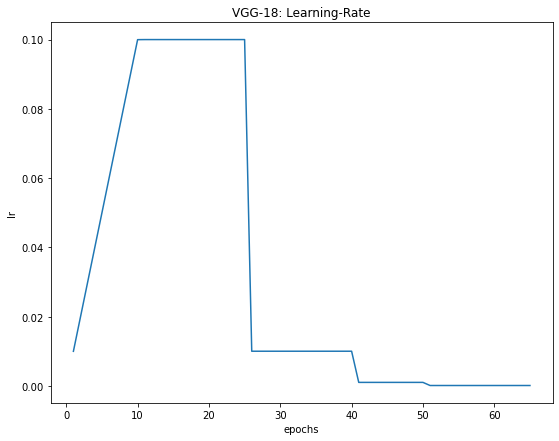

In [62]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['lr'] for k in training_history_lr_scheduler.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("VGG-18: Learning-Rate")
plt.show()